# Problem 3 -- Steane Code

Solver: 房伯文

### (a) Part 1 Encoding circuit

In [342]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
# from qiskit.quantum_info import Operator

In [403]:
# parameters
logical_state = "zero"
# logical_state = "one"

In [404]:
def bell_state(qc, a, b):
    qc.h(a)
    qc.cx(a, b)

In [405]:
def encoding(qc):
    bell_state(qc, 0, 4)
    bell_state(qc, 1, 2)
    bell_state(qc, 3, 5)
    qc.cx(6, 1)
    qc.cx(6, 0)
    qc.cx(6, 3)
    qc.cx(4, 6)
    qc.cx(3, 4)
    qc.cx(5, 6)
    qc.cx(2, 6)
    qc.cx(1, 5)
    qc.cx(0, 2)
    # qc.save_statevector(label="psi_f")

    return qc

In [406]:
import numpy as np
one_state = np.zeros(2**7, dtype=complex)
one_state[2**6] = 1
zero_state = np.zeros(2**7, dtype=complex)
zero_state[0] = 1


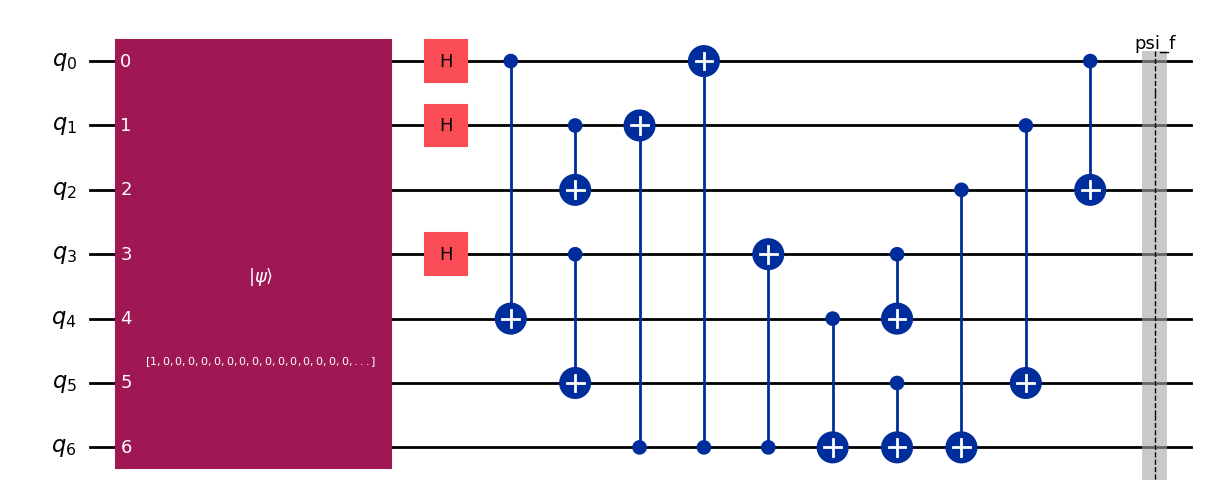

In [407]:
qc_init = QuantumCircuit(7)
if logical_state == "zero":
    qc_init.initialize(zero_state)
else:
    qc_init.initialize(one_state)

qc = QuantumCircuit(7)
encoding(qc)

qc_encoding = qc.compose(qc_init, front=True)
qc_encoding.save_statevector(label="psi_f")
qc_encoding.draw("mpl")

In [ ]:
sim = AerSimulator(method="statevector")
qc_t = transpile(qc_encoding, sim)
result = sim.run(qc_t).result()
psi = result.data()["psi_f"]
psi = psi.reverse_qargs()

threshold = 1e-10
nonzero_indices = np.where(abs(psi.data) > threshold)[0]
# print(nonzero_indices.dtype)
for idx in nonzero_indices:
    print(f"|{idx:07b}>: {psi.data[idx]}")
# print(psi)

|0000000>: (0.35355339059327384+0j)
|0001111>: (0.3535533905932738+0j)
|0110011>: (0.3535533905932738+0j)
|0111100>: (0.35355339059327373+0j)
|1010101>: (0.3535533905932738+0j)
|1011010>: (0.35355339059327373+0j)
|1100110>: (0.35355339059327373+0j)
|1101001>: (0.3535533905932737+0j)


### (a) Part 2: Reverse Circuit (decoding)

- Here, we just use the `.inverse()` function to get the decoding circuit, since all the `H` and `CNOT` gates are self-reversable.

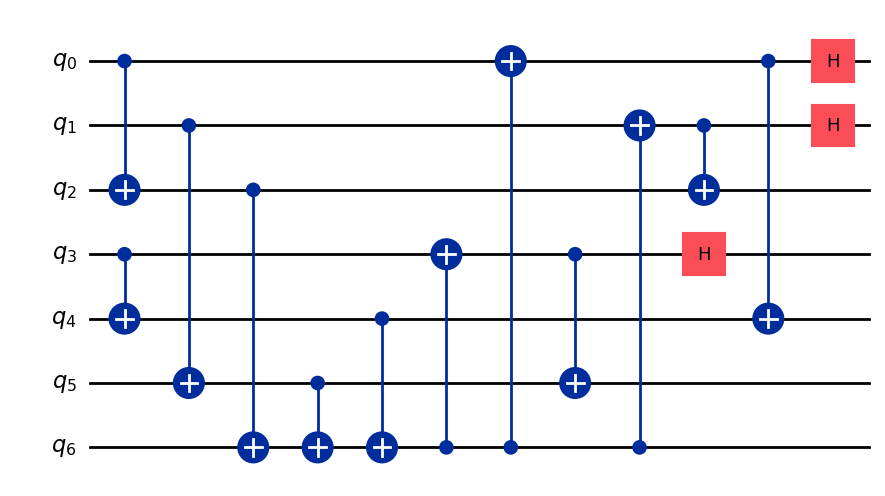

In [349]:
qc_decoding = qc.inverse()
qc_decoding.draw("mpl")

### （b）Stablizer

- We first construct a measurement circuit `qc_measure` and compose it with the original `qc_encoding` to gain our final result

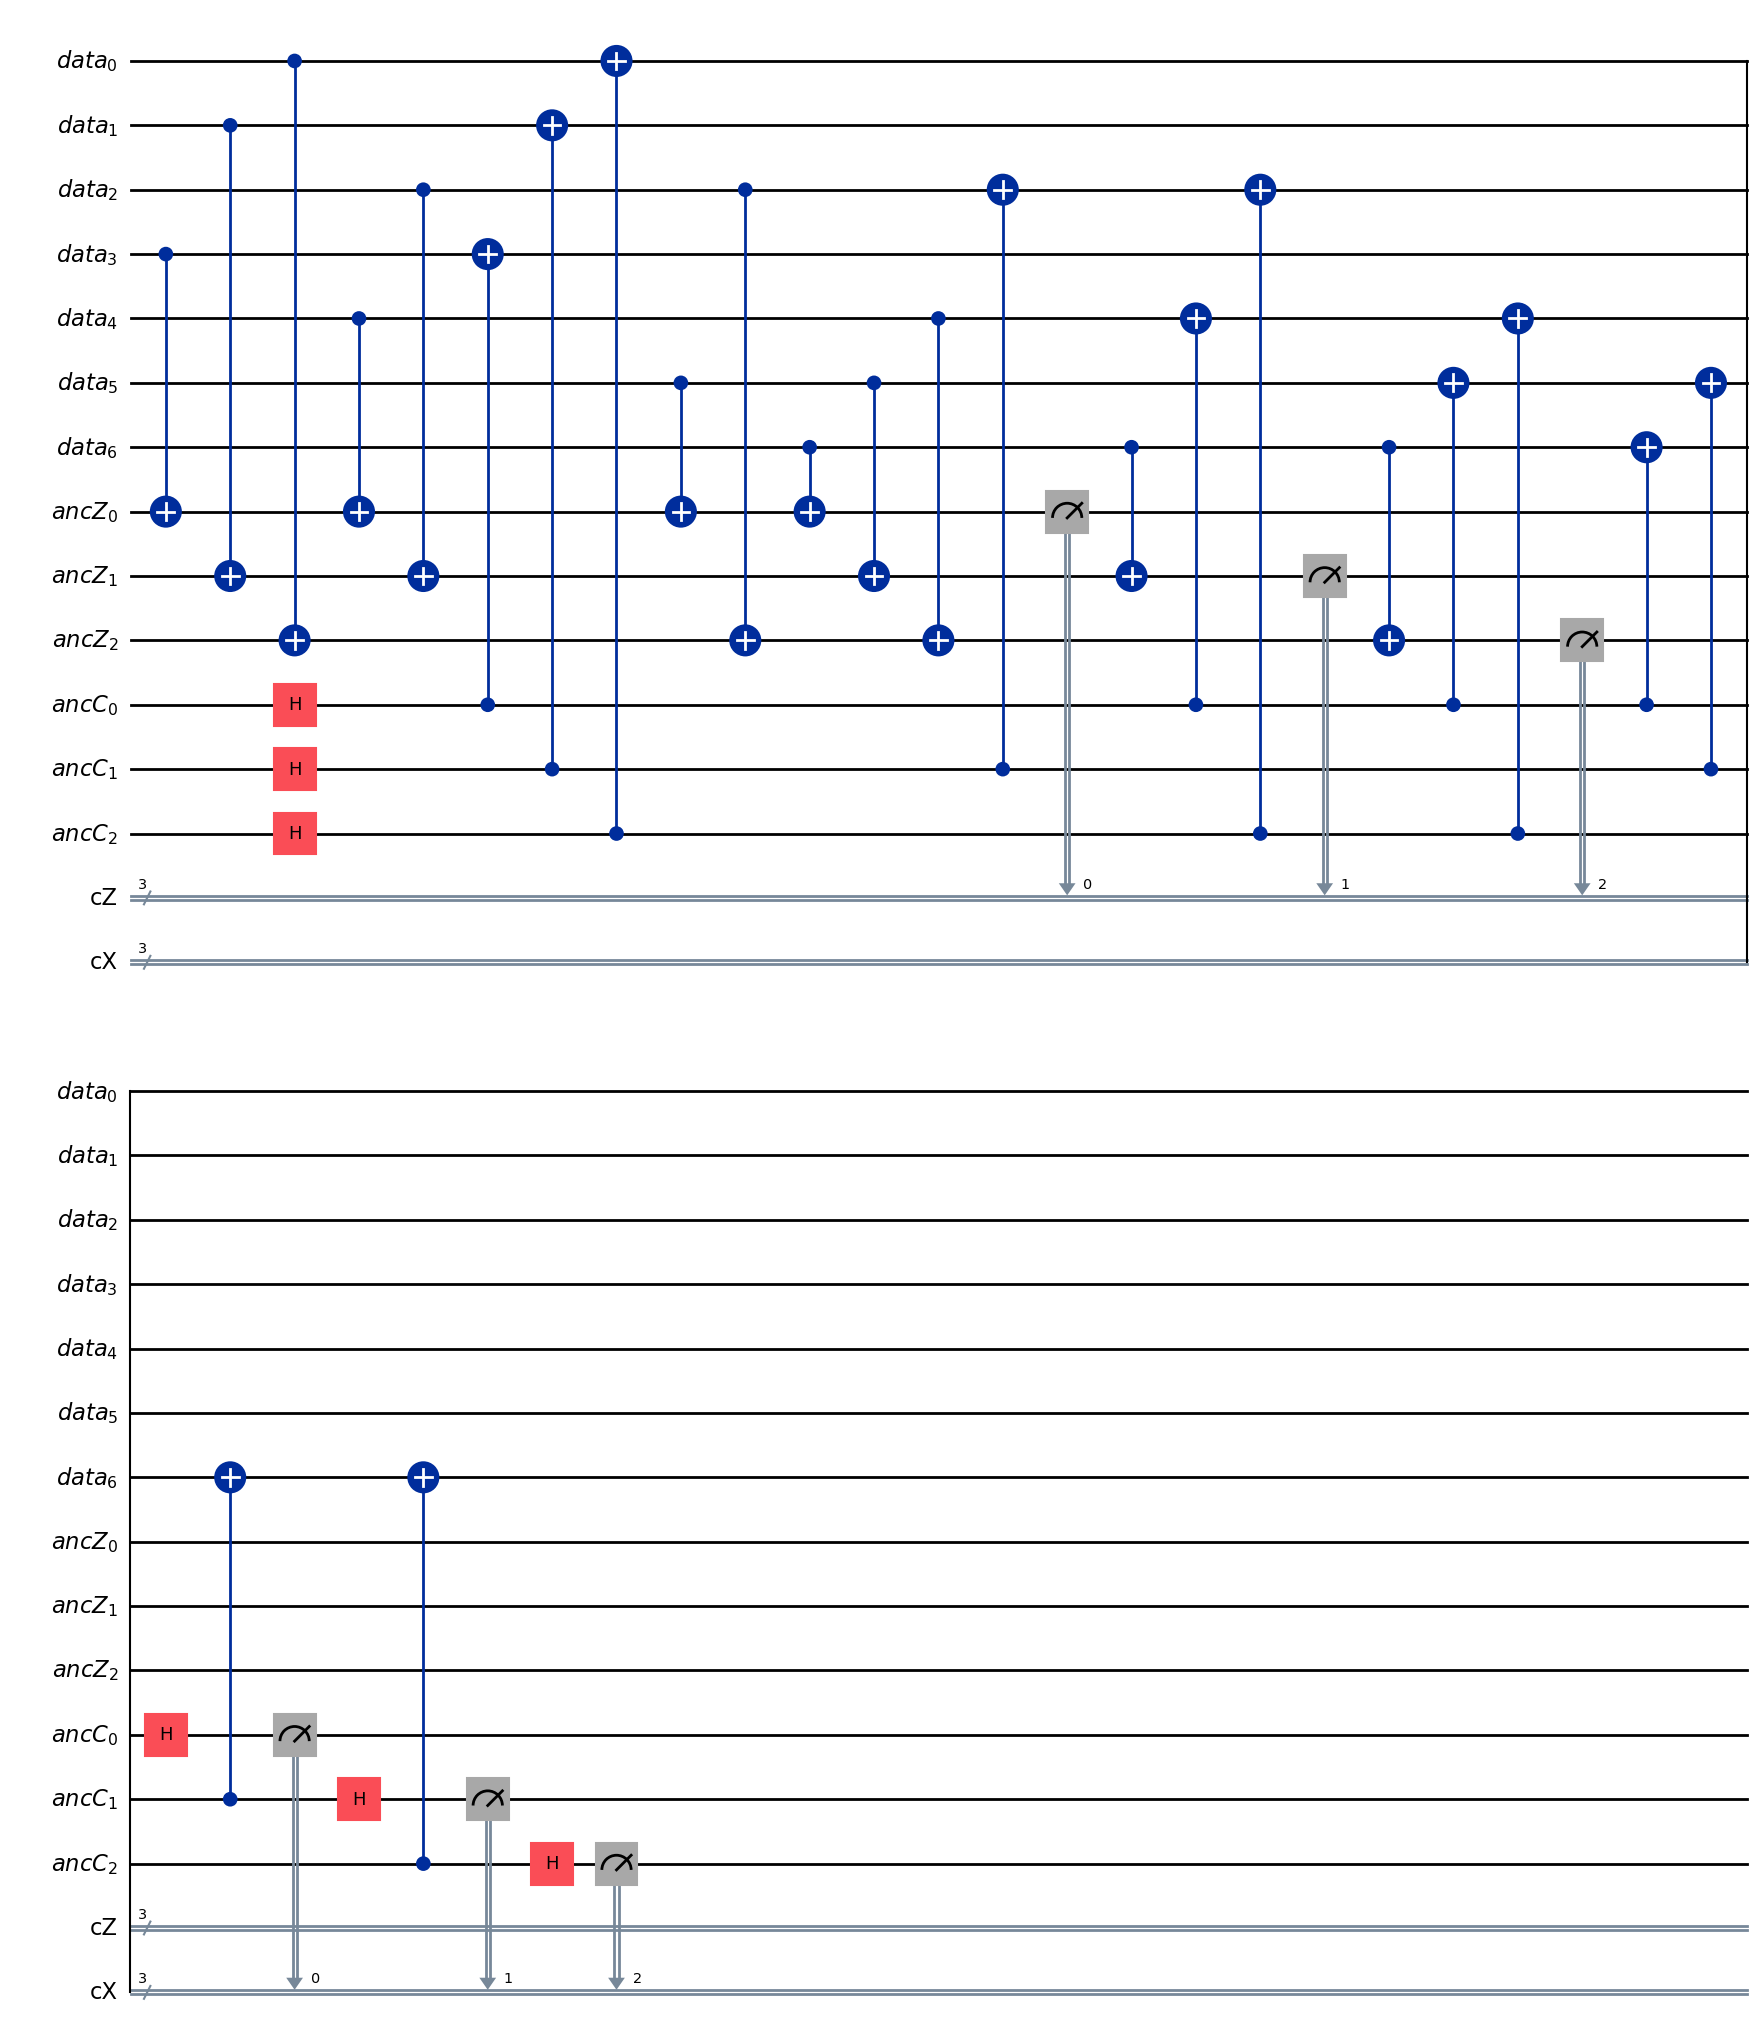

In [350]:
q = QuantumRegister(7, name="data")
aZ = QuantumRegister(3, name="ancZ")
aX = QuantumRegister(3, name="ancC")
cZ = ClassicalRegister(3, name="cZ")
cX = ClassicalRegister(3, name="cX")

qc_measure = QuantumCircuit(q, aZ, aX, cZ, cX)

Z_stabs = [
    [3,4,5,6],
    [1,2,5,6],
    [0,2,4,6],
]
X_stabs = [
    [3,4,5,6],
    [1,2,5,6],
    [0,2,4,6],
]

for idx, sites in enumerate(Z_stabs):
    anc = aZ[idx]
    for qb in sites:
        qc_measure.cx(q[qb], anc)
    qc_measure.measure(anc, cZ[idx])

for idx, sites in enumerate(X_stabs):
    anc = aX[idx]
    qc_measure.h(anc)
    for qb in sites:
        qc_measure.cx(anc, q[qb])
    qc_measure.h(anc)
    qc_measure.measure(anc, cX[idx])

qc_measure.draw(output="mpl")

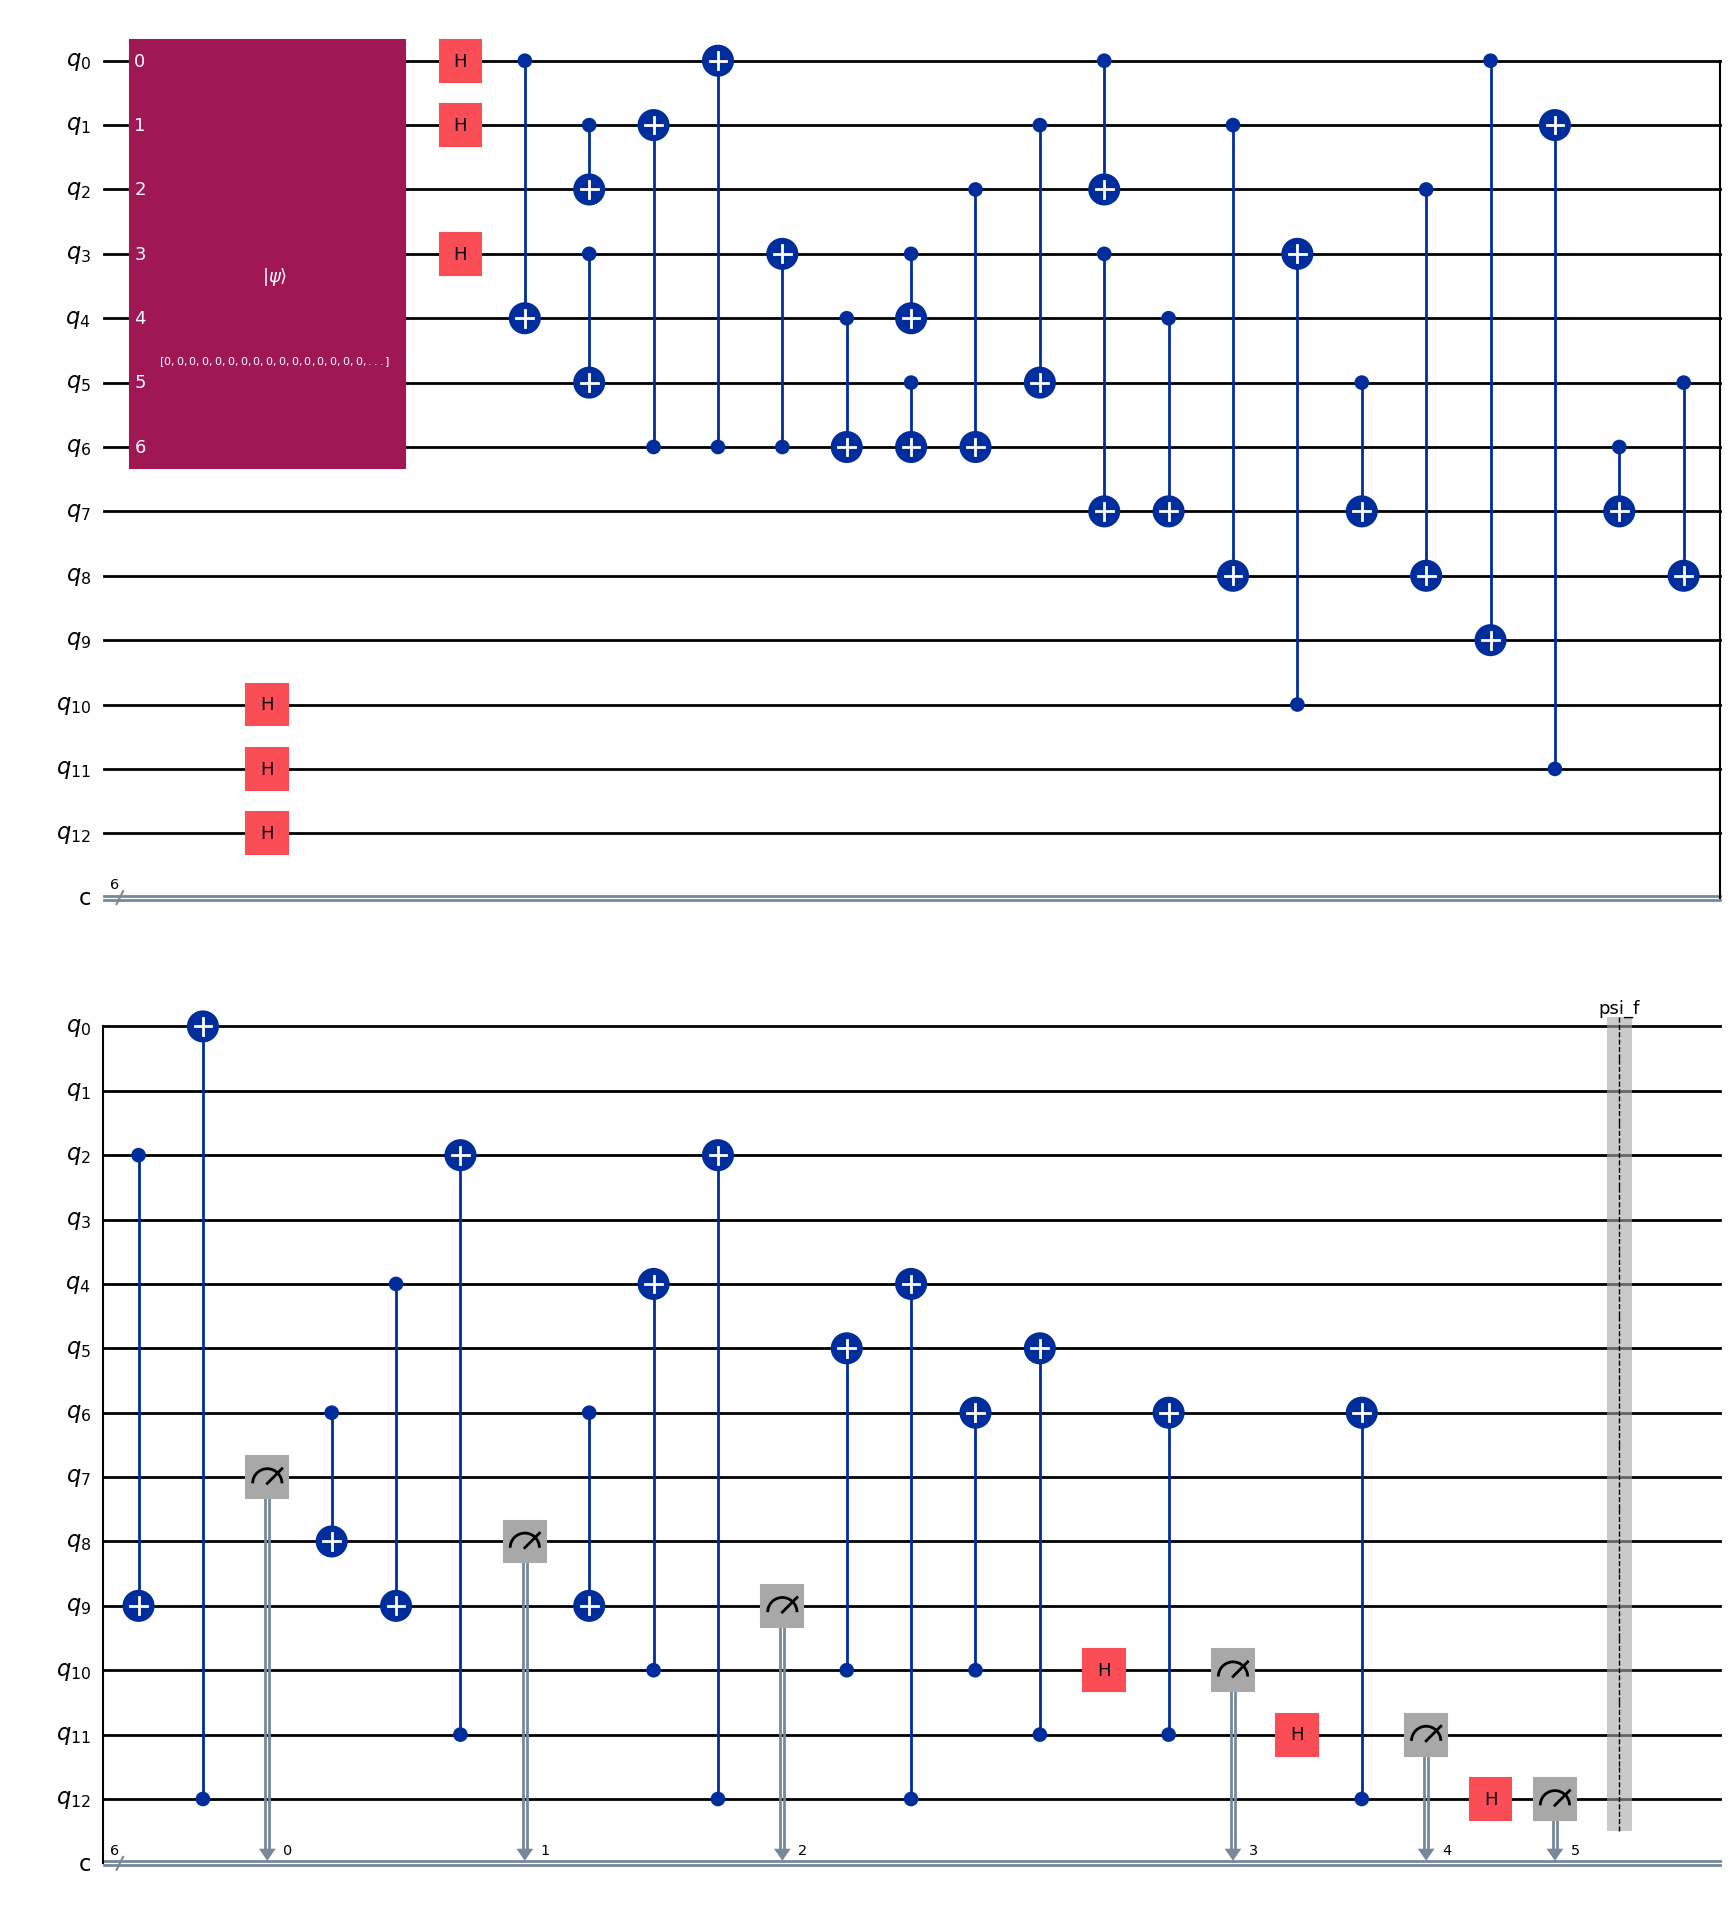

In [351]:
# Combine qc_encoding and qc_measure
qc_total = QuantumCircuit(7+3+3, 6)

qc_total = qc_total.compose(qc_encoding)
qc_total = qc_total.compose(qc_measure)
qc_total.data = [
    instr for instr in qc_total.data
    if not (instr.operation.name == "save_statevector")
]
qc_total.save_statevector(label="psi_f")
qc_total.draw("mpl")

In [352]:
sim_total = AerSimulator(method="statevector")

qc_total_t = transpile(qc_total, sim_total)
# result = sim_total.run(qc_total_t, shots=100).result()
result = sim_total.run(qc_total_t).result()

# counts = result.get_counts()
psi = result.data()["psi_f"]
psi = psi.reverse_qargs()
print(psi)

threshold = 1e-10
nonzero_indices = np.where(abs(psi.data) > threshold)[0]
# print(nonzero_indices.dtype)
for idx in nonzero_indices:
    print(f"|{idx:013b}>: {psi.data[idx]}")

# from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
# psi = Statevector(psi)
# rho = DensityMatrix(psi)
# # rho = psi.to_density_matrix()
# qb_trace = range(7)
# rho_sub = partial_trace(rho, qb_trace)
# psi_sub = rho_sub.to_statevector()
# print(rho_sub)
# print(psi_sub)

Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
|0010110000000>: (0.3535533905932738-6.4946704217662e-17j)
|0011001000000>: (0.3535533905932738-6.494670421766199e-17j)
|0100101000000>: (0.3535533905932738-6.494670421766199e-17j)
|0101010000000>: (0.3535533905932738-6.494670421766198e-17j)
|1000011000000>: (0.3535533905932738-6.494670421766199e-17j)
|1001100000000>: (0.3535533905932738-6.494670421766199e-17j)
|1110000000000>: (0.3535533905932738-6.494670421766199e-17j)
|1111111000000>: (0.3535533905932738-6.494670421766198e-17j)


- It is obvious that this state is a tensor product of encoded pure 1 state and the results of the ancilla qubits.
- From the result, we can see, all ancilla qubits are in state 1, which means that the original state has eigenvalue 1 for every stablizer.

### (c) Correction Circuit

In [362]:
def reverse_bits(x, n_bits):
    res = 0
    for i in range(n_bits):
        if x & (1 << i):
            res |= 1 << (n_bits - 1 - i)
    return res

# for i in range(7):
#     print(format(reverse_bits(i+1, 3),"03b"))
#     print(reverse_bits(i+1, 3))

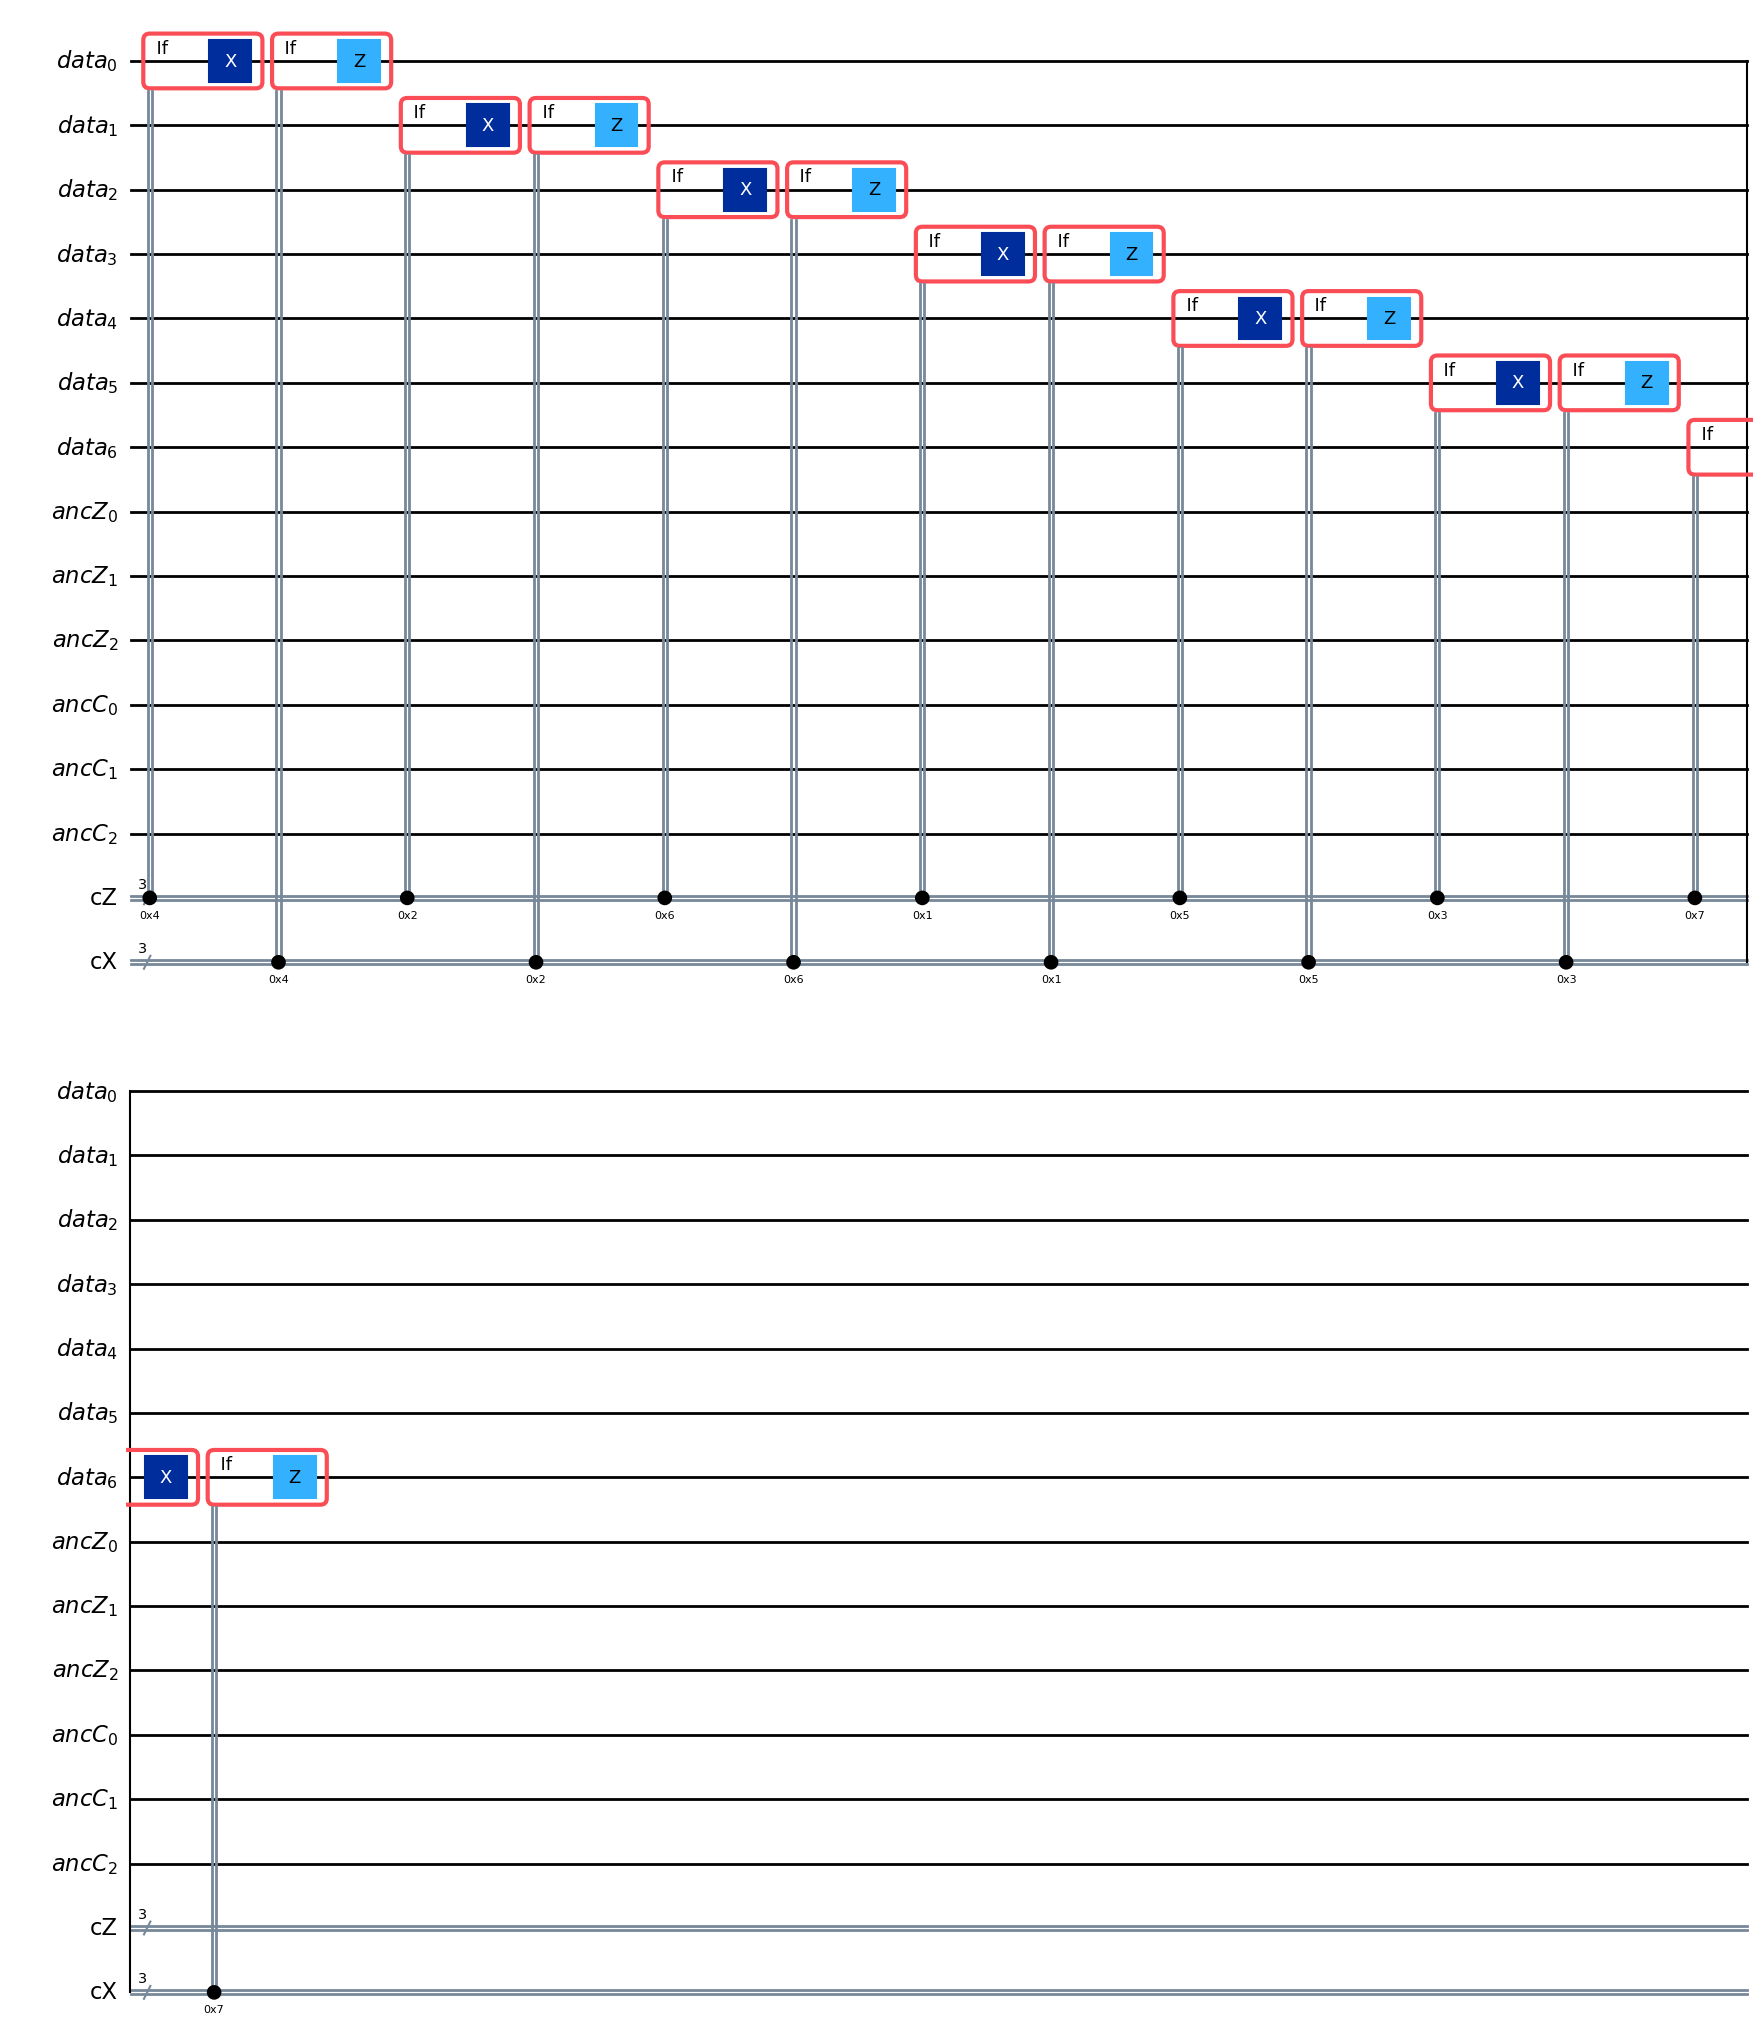

In [363]:
qc_correction = QuantumCircuit(q, aZ, aX, cZ, cX)

n_bits = 3
# NOTE: We need to reverse bit to align with the little-endian property of classical bits
# correct x syndrome
for i in range(7):
    rev = reverse_bits(i+1, n_bits)
    with qc_correction.if_test((cZ, rev)):
        qc_correction.x(q[i])
# correct z syndrome
# for i in range(7):
    # rev = reverse_bits(i, n_bits)
    with qc_correction.if_test((cX, rev)):
        qc_correction.z(q[i])

qc_correction.draw("mpl")

### (d) Combined circuit and Error correction

In [377]:
from qiskit.circuit.library import UnitaryGate
import random
def create_error(qc):
    mod = random.randint(1, 4)
    match mod:
        case 1:
            qc.x(0)
            print("Error X_1 applied")
        case 2:
            qc.y(1)
            print("Error Y_2 applied")
        case 3:
            qc.z(2)
            print("Error Z_3 applied")
        case 4:
            I = np.eye(2)
            X = np.array([[0,1],[1,0]])
            Y = np.array([[0,-1j],[1j,0]])
            Z = np.array([[1,0],[0,-1]])
            U = 0.5 * (I + 1j*(X+Y+Z))
            gate = UnitaryGate(U, label="U=(I+i(X+Y+Z))/2")
            qc.append(gate, [3])
            print("Error U=(I+i(X+Y+Z))/2 applied")
        case _:
            raise ValueError("the error type must be in {1, 2, 3, 4}")


Error U=(I+i(X+Y+Z))/2 applied


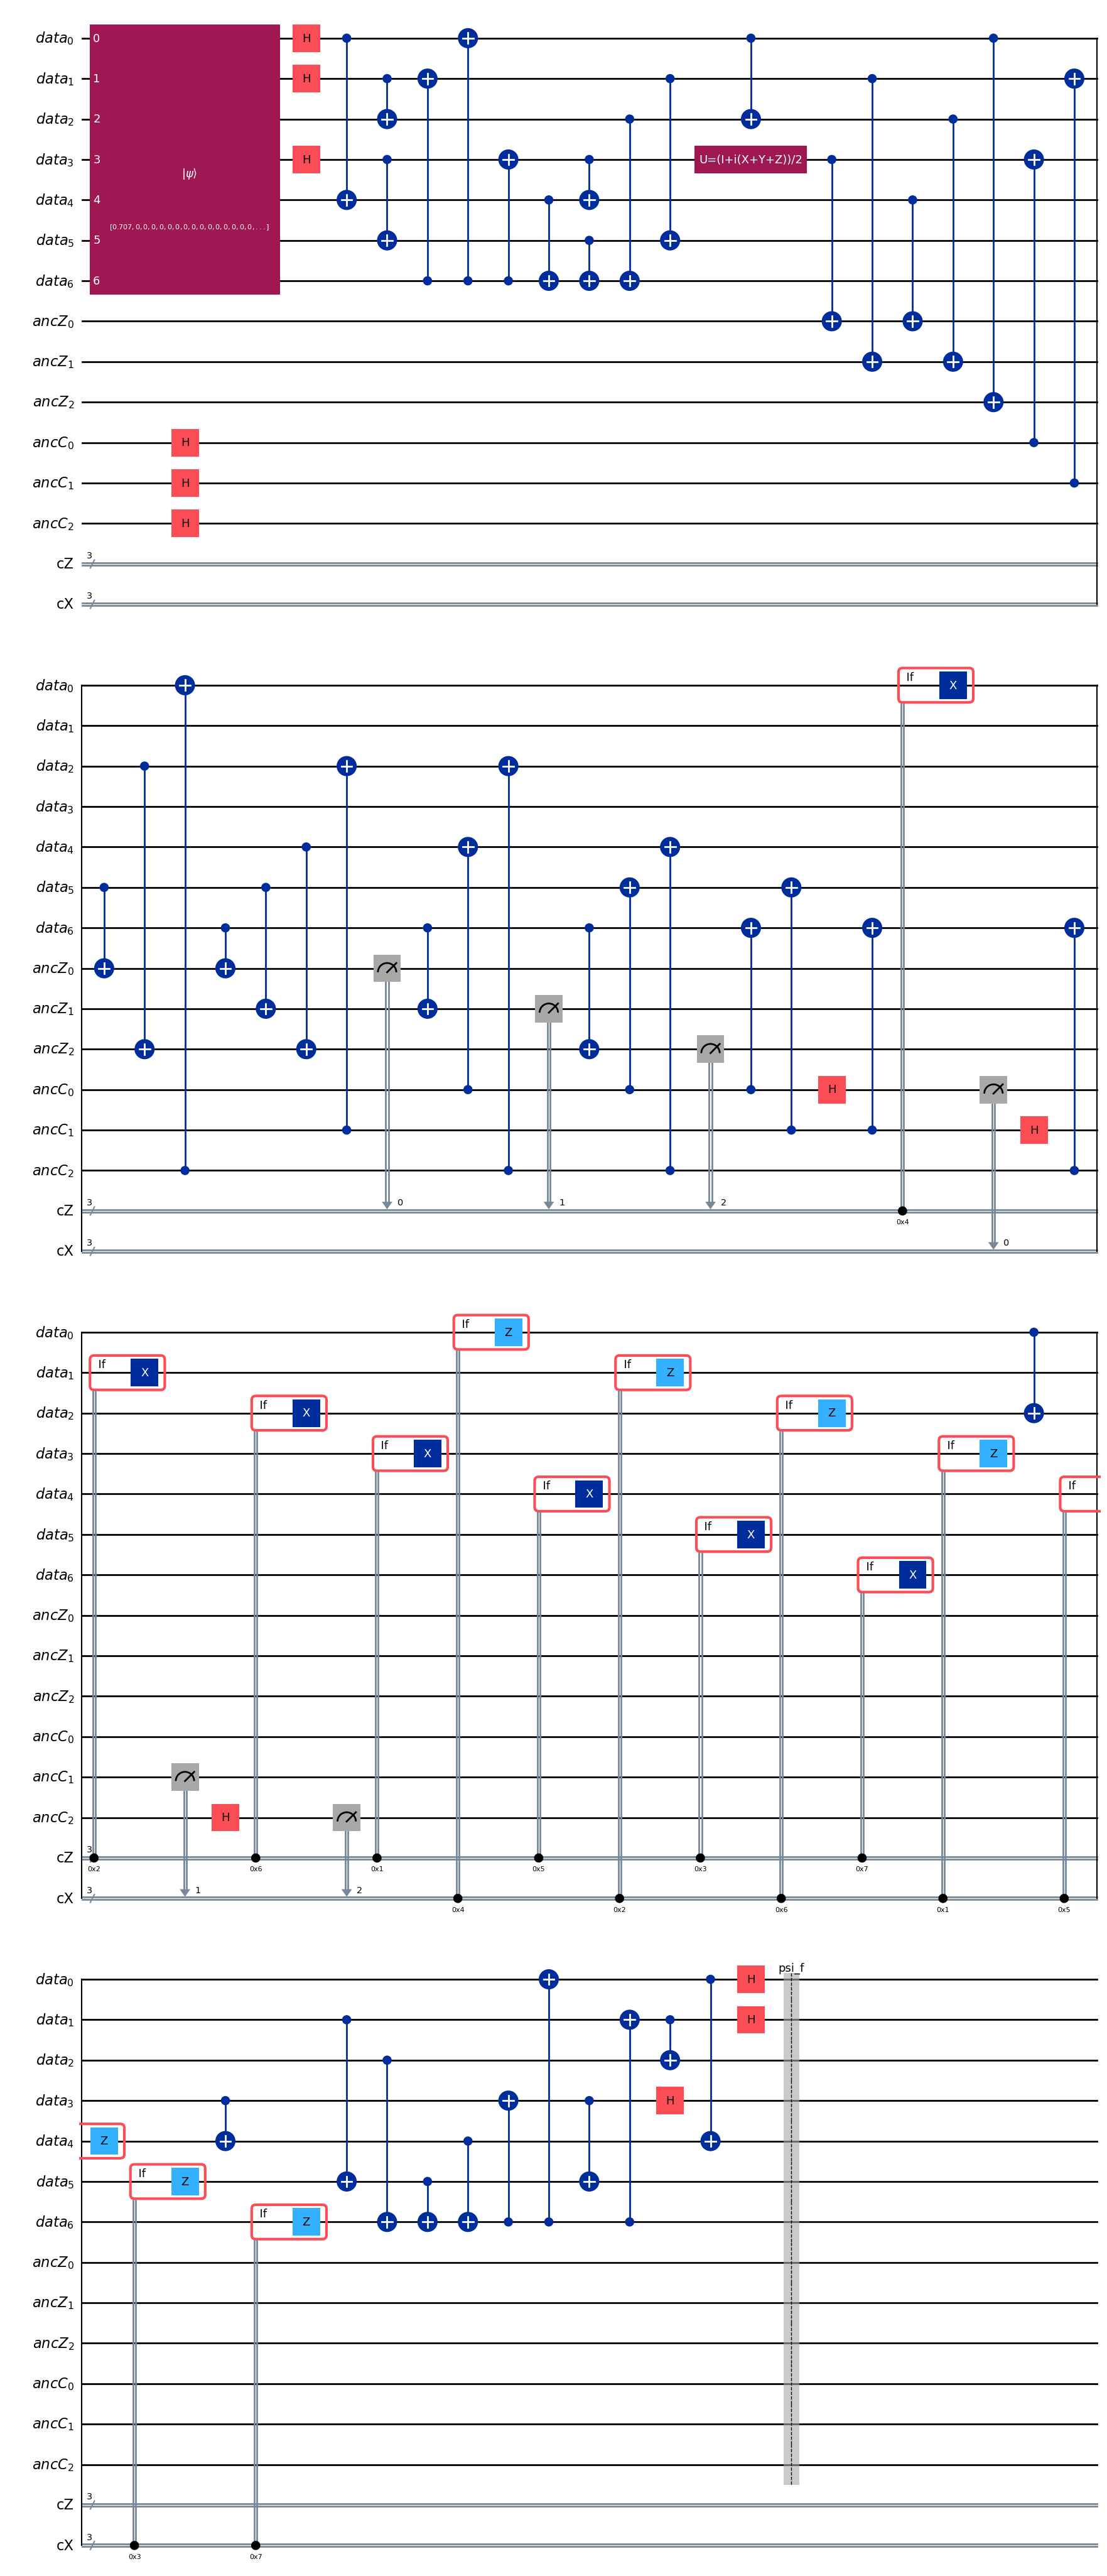

In [381]:
qc_combine = QuantumCircuit(q, aZ, aX, cZ, cX)

import copy
qc_encoding2 = copy.deepcopy(qc_encoding)
qc_encoding2.data = [
    instr for instr in qc_encoding2.data
    if instr.operation.name not in ("save_statevector", "initialize")
]
# initialize with \frac{1}{\sqrt{2}}(|0>+i|1>)
psi_i = (zero_state + 1j * one_state) / np.sqrt(2)
qc_init2 = QuantumCircuit(7)
qc_init2.initialize(psi_i)

qc_combine = qc_combine.compose(qc_init2)
qc_combine = qc_combine.compose(qc_encoding2)

# add error
create_error(qc_combine)

qc_combine = qc_combine.compose(qc_measure)
qc_combine = qc_combine.compose(qc_correction)

# use decoding circuit to see the result
qc_combine = qc_combine.compose(qc_decoding)
qc_combine.save_statevector("psi_f")

qc_combine.draw("mpl")

In [410]:
sim_combine = AerSimulator(method="statevector")

qc_combine_t = transpile(qc_combine, sim_combine)
# result = sim_total.run(qc_total_t, shots=100).result()
result_combine = sim_total.run(qc_combine_t).result()

# counts = result.get_counts()
psi = result_combine.data()["psi_f"]
psi = psi.reverse_qargs()
# t print(psi)

threshold = 1e-10
nonzero_indices = np.where(abs(psi.data) > threshold)[0]
# print(nonzero_indices.dtype)
for idx in nonzero_indices:
    print(f"|{idx:013b}>: {psi.data[idx]}")

|0000000000000>: (0.7071067811865475-2.0176939725871287e-16j)
|0000001000000>: (3.1461979272660923e-16+0.7071067811865475j)


- By running the last two cell several times, we can see that whatever the error is, the correction circuit can always correct it.
- Note that the statevector contains 7 data qubits and 6 ancilla qubits, when analysing the data, we only need to consider the first part (data[0] to data[6]), and see if they recover $\frac{1}{\sqrt{2}}\left(|0_L \rangle + i|1_L\rangle \right)$, namely $|0000000\rangle, |0000001\rangle$ (equivalent up to a constant factor)